# Processing L.A. trash collection data

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import datetime as dt

In [3]:
import altair as alt
import altair_latimes as lat
import matplotlib.pyplot as plt

In [4]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### Read the collection data

In [5]:
src = pd.read_csv(
    "data/raw/trash.csv",
    parse_dates=[
        "datetime",
    ],
    dtype={
        "year": "str",
        "quarter": "str",
        "day": "str",
        "month": "str",
        "weekday": "str",
    },
)

In [6]:
df = src.copy()

In [7]:
df.head()

,district,route,datetime,site,ticketnumber,tons,commoditycode,generalcommodity,year,quarter,day,month,weekday,monthname,month_year,days_in_month,apmonth
0,CSLA DCT,LH1,2019-10-01,Republic Sunshine Canyon Landfill,NaN,2.0,H,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
1,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
2,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
3,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.
4,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10,31,Oct.


In [8]:
df["month_year"] = pd.to_datetime(df["month_year"], format="%Y-%m")

In [9]:
df.sort_values("month")["apmonth"].unique()

array(['Jan.', 'Oct.', 'Nov.', 'Dec.', 'Feb.', 'March', 'April', 'May',
       'June', 'July', 'Aug.', 'Sept.'], dtype=object)

In [10]:
df.year.unique()

array(['2019', '2020', '2021', '2016', '2017', '2018'], dtype=object)

### Annual trash volumn (excluding 2021)

In [11]:
years = ["2019", "2020", "2016", "2017", "2018"]

In [12]:
totals = df[df["year"].isin(years)].groupby(["year"]).agg({"tons": sum}).reset_index()
totals

,year,tons
0,2016,1547453.03
1,2017,1594390.39
2,2018,1570290.11
3,2019,1615392.92
4,2020,1771969.26


### Change in 2020 from mean of previous four years

In [13]:
mean = totals.iloc[0:3]["tons"].mean()

In [14]:
((totals.iloc[4]["tons"] - mean) / mean * 100).round(2)

12.81

### Totals by commodity and year

In [15]:
years_totals = (
    df[df["year"].isin(years)]
    .groupby(["year", "generalcommodity"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)
years_totals

,year,generalcommodity,tons
19,2020,Yard Trimmings,476780.62
18,2020,Refuse,949701.52
17,2020,Recycling,263448.86
16,2020,Bulky,82038.26
15,2019,Yard Trimmings,432255.30
14,2019,Refuse,899871.41
13,2019,Recycling,210421.93
12,2019,Bulky,72844.28
11,2018,Yard Trimmings,412491.80
10,2018,Refuse,883330.24


### Tons per day

In [16]:
years_totals["tons_per_day"] = years_totals["tons"] / 365

In [17]:
area = (
    alt.Chart(years_totals)
    .mark_bar(opacity=0.9)
    .encode(
        x=alt.X(
            "year:O",
            axis=alt.Axis(grid=False),
            title="Month/Year",
        ),
        y=alt.Y(
            "tons:Q",
            axis=alt.Axis(
                format="",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            title="Tons",
        ),
        color=alt.Color(
            "generalcommodity:N",
            title="Type",
            scale=alt.Scale(scheme="category20"),
        ),
    )
    .properties(width=500, height=400, title="City of L.A. trash totals, by year")
)

(area).configure_view(strokeOpacity=0)

alt.Chart(...)

### Pivot the frame

In [18]:
years_totals_pivot = years_totals.pivot_table(
    columns="year", index="generalcommodity", values="tons_per_day"
).reset_index()

### What's the pct change in tonage from previous year? 

In [19]:
years_totals_pivot["change"] = (
    (years_totals_pivot["2020"] - years_totals_pivot["2019"])
    / years_totals_pivot["2019"]
    * 100
).round(2)

In [20]:
years_totals_pivot

year,generalcommodity,2016,2017,2018,2019,2020,change
0,Bulky,158.042301,177.453562,186.450137,199.573370,224.762356,12.62
1,Recycling,608.314082,601.081370,565.517178,576.498438,721.777699,25.20
2,Refuse,2353.121288,2409.927863,2420.082849,2465.401123,2601.921973,5.54
3,Yard Trimmings,1120.119671,1179.730055,1130.114521,1184.261096,1306.248274,10.30


### Group by years and months

In [21]:
year_grp = (
    df.groupby(["year", "apmonth", "month_year", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)

In [22]:
recycling_year_grp = (
    df[df["generalcommodity"] == "Recycling"]
    .groupby(["year", "apmonth", "month_year", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)

In [23]:
year_grp["tons_per_day"] = (year_grp["tons"] / year_grp["days_in_month"]).round()
recycling_year_grp["tons_per_day"] = (
    recycling_year_grp["tons"] / recycling_year_grp["days_in_month"]
).round()

In [24]:
year_grp = year_grp.sort_values("month_year", ascending=True)

In [25]:
from altair import datum

text = (
    alt.Chart(year_grp.query("tons_per_day == tons_per_day.max()"))
    .mark_text(
        dx=30,
        dy=-15,
        color="#000000",
        font="Benton Gothic",
        fontWeight="bolder",
        fontSize=12,
    )
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
        ),
        y=alt.Y("tons_per_day:Q"),
        text=alt.Text("year"),
    )
)

line = (
    alt.Chart(year_grp)
    .mark_line(interpolate="monotone", size=2)
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
            axis=alt.Axis(grid=False, tickCount=6),
            title=" ",
        ),
        y=alt.Y(
            "tons_per_day",
            axis=alt.Axis(
                format="",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            scale=alt.Scale(domain=[3000, 6000]),
            title=" ",
        ),
        color=alt.Color(
            "year",
            title=" ",
            scale=alt.Scale(
                domain=["2016", "2017", "2018", "2019", "2020"],
                range=["lightgray", "lightgray", "lightgray", "lightgray", "steelblue"],
            ),
            legend=None,
        ),
    )
)
(line + text).properties(
    width=600, height=400, title="Tons per day (all types) collected"
).configure_view(strokeOpacity=0).configure_axis(labelFontSize=13)

alt.LayerChart(...)

In [26]:
from altair import datum

text = (
    alt.Chart(recycling_year_grp.query("tons_per_day == tons_per_day.max()"))
    .mark_text(
        dx=30,
        dy=-15,
        color="#000000",
        font="Benton Gothic",
        fontWeight="bolder",
        fontSize=12,
    )
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
        ),
        y=alt.Y("tons_per_day:Q"),
        text=alt.Text("year"),
    )
)

line = (
    alt.Chart(recycling_year_grp)
    .mark_line(interpolate="monotone", size=2)
    .encode(
        x=alt.X(
            "apmonth:O",
            sort=[
                "Jan.",
                "Feb.",
                "March",
                "April",
                "May",
                "June",
                "July",
                "Aug.",
                "Sept.",
                "Oct.",
                "Nov.",
                "Dec.",
            ],
            axis=alt.Axis(grid=False, tickCount=6),
            title=" ",
        ),
        y=alt.Y(
            "tons_per_day",
            axis=alt.Axis(
                format="",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            scale=alt.Scale(domain=[200, 1000]),
            title=" ",
        ),
        color=alt.Color(
            "year",
            title=" ",
            scale=alt.Scale(
                domain=["2016", "2017", "2018", "2019", "2020"],
                range=["lightgray", "lightgray", "lightgray", "lightgray", "steelblue"],
            ),
            legend=None,
        ),
    )
)
(line + text).properties(
    width=600,
    height=400,
    title="Tons per day in (recycling) collected",
).configure_view(strokeOpacity=0).configure_axis(labelFontSize=13)

alt.LayerChart(...)

In [27]:
month_grp = (
    df[df["year"].isin(years)]
    .groupby(["month_year", "year", "month", "generalcommodity", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["month_year"], ascending=False)
)

In [28]:
month_grp["tons_per_day"] = month_grp["tons"] / month_grp["days_in_month"]

In [29]:
month_grp.head()

,month_year,year,month,generalcommodity,days_in_month,tons,tons_per_day
239,2020-12-01,2020,12,Yard Trimmings,31,34938.54,1127.049677
238,2020-12-01,2020,12,Refuse,31,84724.20,2733.038710
237,2020-12-01,2020,12,Recycling,31,23514.86,758.543871
236,2020-12-01,2020,12,Bulky,31,6401.77,206.508710
235,2020-11-01,2020,11,Yard Trimmings,30,37207.13,1240.237667


### Chart it

In [30]:
area = (
    alt.Chart(month_grp)
    .mark_bar(opacity=0.9, size=7)
    .encode(
        x=alt.X(
            "month_year:T",
            axis=alt.Axis(format="%b %Y", grid=False, tickCount=6),
            title="Month/Year",
        ),
        y=alt.Y(
            "tons_per_day:Q",
            axis=alt.Axis(
                format="",
                tickCount=4,
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
            ),
            title="Tons per day",
        ),
        color=alt.Color(
            "generalcommodity:N",
            title="Type",
            scale=alt.Scale(scheme="category20"),
        ),
    )
    .properties(width=500, height=400, title="City of L.A. trash totals, by year")
)

(area).configure_view(strokeOpacity=0)

alt.Chart(...)

In [31]:
route_commodity_years = (
    df.groupby(["year", "route", "generalcommodity"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by="tons", ascending=False)
)

In [32]:
route_commodity_years.head()

,year,route,generalcommodity,tons
2513,2020,AA3,Refuse,31134.82
2479,2020,AA2,Refuse,30769.86
2543,2020,AA4,Refuse,30269.68
2560,2020,AA7,Refuse,29913.31
2554,2020,AA5,Refuse,29534.81


In [33]:
daily_grp = (
    df.groupby(["datetime", "generalcommodity", "days_in_month"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["datetime"], ascending=False)
)

In [34]:
month_grp

,month_year,year,month,generalcommodity,days_in_month,tons,tons_per_day
239,2020-12-01,2020,12,Yard Trimmings,31,34938.54,1127.049677
238,2020-12-01,2020,12,Refuse,31,84724.20,2733.038710
237,2020-12-01,2020,12,Recycling,31,23514.86,758.543871
236,2020-12-01,2020,12,Bulky,31,6401.77,206.508710
235,2020-11-01,2020,11,Yard Trimmings,30,37207.13,1240.237667
...,...,...,...,...,...,...,...
7,2016-02-01,2016,2,Yard Trimmings,29,31317.08,1079.899310
2,2016-01-01,2016,1,Refuse,31,68942.76,2223.960000
1,2016-01-01,2016,1,Recycling,31,18838.48,607.692903
3,2016-01-01,2016,1,Yard Trimmings,31,30707.11,990.551935


In [35]:
alt.Chart(month_grp, title="L.A. trash spiked during pandemic").mark_rect().encode(
    x=alt.X(
        "year(month_year):O",
        axis=alt.Axis(
            tickCount=4, gridColor="#dddddd", offset=6, tickSize=0, domainOpacity=0
        ),
        title=" ",
    ),
    y=alt.Y(
        "month(month_year):O",
        title=" ",
        axis=alt.Axis(
            tickCount=4, gridColor="#dddddd", offset=6, tickSize=0, domainOpacity=0
        ),
    ),
    color=alt.Color(
        "mean(tons_per_day):Q", scale=alt.Scale(scheme="blues"), title="Tons/day"
    ),
).properties(width=320, height=400).configure_view(strokeOpacity=0)

alt.Chart(...)

---

### Routes

In [36]:
df.head()

,district,route,datetime,site,ticketnumber,tons,commoditycode,generalcommodity,year,quarter,day,month,weekday,monthname,month_year,days_in_month,apmonth
0,CSLA DCT,LH1,2019-10-01,Republic Sunshine Canyon Landfill,NaN,2.0,H,Bulky,2019,4,1,10,1,October,2019-10-01,31,Oct.
1,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10-01,31,Oct.
2,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10-01,31,Oct.
3,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10-01,31,Oct.
4,CSLA DCT,LI6,2019-10-01,Republic Sunshine Canyon Landfill,NaN,0.0,I,Bulky,2019,4,1,10,1,October,2019-10-01,31,Oct.


In [37]:
districts_grp = (
    df[df["year"] != "2021"]
    .groupby(["year", "generalcommodity", "route"])
    .agg({"tons": sum})
    .reset_index()
    .sort_values(by=["year"], ascending=False)
)

In [38]:
districts_grp.head()

,year,generalcommodity,route,tons
3127,2020,Yard Trimmings,VE30,6.49
2669,2020,Recycling,AR20,6173.22
2677,2020,Recycling,AR28,10.51
2676,2020,Recycling,AR27,122.09
2675,2020,Recycling,AR26,358.10


In [39]:
route_pivot = pd.pivot_table(
    districts_grp,
    columns="year",
    values="tons",
    index=["route"],
    aggfunc={"tons": "sum"},
).reset_index()

In [40]:
route_pivot.columns = route_pivot.columns.astype(str)

In [41]:
before = ["2016", "2017", "2018", "2019"]
after = ["2021"]

In [42]:
route_pivot["before"] = route_pivot[before].mean(axis=1)

In [43]:
route_pivot["change"] = (
    (route_pivot["2020"] - route_pivot["before"]) / route_pivot["before"] * 100
).round(2)

In [44]:
route_pivot[route_pivot["2020"] > 5000].sort_values("change", ascending=False).head(30)

year,route,2016,2017,2018,2019,2020,before,change
128,AZ1,4338.91,6140.18,3710.37,4488.57,8761.45,4669.5075,87.63
435,SA3,8569.28,8764.95,9368.82,10558.65,12019.40,9315.4250,29.03
172,FB5,2668.51,3879.50,5046.02,4989.40,5341.95,4145.8575,28.85
66,AR20,5368.96,3977.07,5119.73,5719.69,6360.05,5046.3625,26.03
168,FB4,3436.47,4743.38,5220.05,5207.60,5793.13,4651.8750,24.53
109,AY3,21947.41,22932.40,21295.56,23847.15,27968.89,22505.6300,24.28
2,AA11,20367.40,21254.33,21112.22,21341.82,26095.41,21018.9425,24.15
448,SY2,5842.81,6180.04,5888.81,6255.54,7485.13,6041.8000,23.89
29,AA36,10161.30,10202.11,10015.03,10927.97,12672.75,10326.6025,22.72
97,AY19,11246.07,12439.36,11716.23,12986.86,14811.03,12097.1300,22.43


---

### Geography

In [45]:
routes = gpd.read_file(
    "data/raw/Sanitation_Maintenance_Districts/Sanitation_Maintenance_Districts.shp"
)

In [46]:
routes.columns = (
    routes.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
)

<AxesSubplot:>

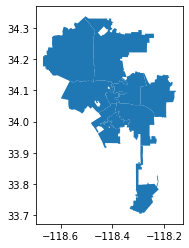

In [47]:
routes.plot()

In [48]:
routes.head(20)

,objectid,name,tooltip,geometry
0,1,RESEDA,District: RESEDA,"POLYGON ((-118.50829 34.33408, -118.50656 34.3..."
1,2,CULVER CITY,District: CULVER CITY,"POLYGON ((-118.38766 34.02913, -118.38729 34.0..."
2,3,HARBOR,District: HARBOR,"POLYGON ((-118.28224 33.92363, -118.28208 33.8..."
3,4,VENICE WESTCHESTER,District: VENICE WESTCHESTER,"POLYGON ((-118.40199 34.05698, -118.40105 34.0..."
4,5,NORTH HOLLYWOOD,District: NORTH HOLLYWOOD,"POLYGON ((-118.50829 34.33408, -118.50397 34.3..."
5,6,NORTH L.A.,District: NORTH L.A.,"POLYGON ((-118.27591 34.15368, -118.27339 34.1..."
6,7,SOUTH L.A.,District: SOUTH L.A.,"POLYGON ((-118.37709 34.05963, -118.37599 34.0..."
7,8,WEST L.A.,District: WEST L.A.,"POLYGON ((-118.56478 34.12979, -118.56311 34.1..."
8,9,HOLLYWOOD,District: HOLLYWOOD,"POLYGON ((-118.36367 34.05811, -118.36514 34.0..."
9,10,BEVERLY HILLS/WEST HOLLYWOOD,District: BEVERLY HILLS/WEST HOLLYWOOD,"POLYGON ((-118.37552 34.08019, -118.37659 34.0..."


---

### Exports

In [50]:
df.to_csv("data/processed/all_data.csv", index=False)

In [51]:
route_pivot.to_csv("data/processed/route_increase.csv", index=False)

In [52]:
month_grp.to_csv("data/processed/month_grp.csv", index=False)

In [53]:
year_grp.to_csv("data/processed/year_grp.csv", index=False)